In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#columnnames = ['y_exit', 'z_exit', 'x_start', 'y_start', 'z_start', 'px_start', 'py_start', 'pz_start', 'reflCoCl', 'reflClCl', 'wl','gpsPosX', 'length_core', 'length_clad', 'rayleighScatterings']

#daten = pd.DataFrame()

#for i in range(0,1199):
#    df_i = pd.read_csv('../data/job_{}.txt'.format(i), sep='\t', skiprows=1, names = columnnames)
#    df_i['jobnumber'] = i
#    daten = pd.concat([daten, df_i])
#daten.to_hdf('../data/data.hdf5', key='Daten')


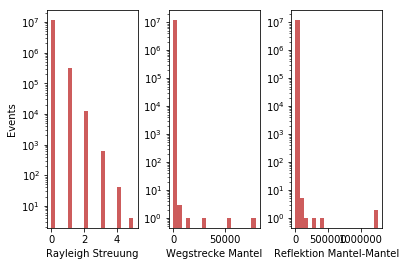

In [2]:
#Daten einlesen
daten = pd.read_hdf('../data/data.hdf5', key='Daten')

# ----Histogramm der Schnittvariablen----
plt.subplot(1,3,1)
plt.hist(daten['rayleighScatterings'], bins = 20, color = 'indianred')
plt.xlabel(r'Rayleigh Streuung')
plt.ylabel(r'Events')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(daten['length_clad'], bins = 20, color = 'indianred')
plt.xlabel(r'Wegstrecke Mantel')
#plt.ylabel(r'Events')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(daten['reflClCl'], bins = 20, color = 'indianred')
plt.xlabel(r'Reflektion Mantel-Mantel')
#plt.ylabel(r'Events')
plt.yscale('log')

plt.subplots_adjust(wspace = 0.35)
plt.savefig('../plots/Simulation/cuts_sim.pdf')

In [3]:
#-----Selektion---------
#Rayleigh
daten = daten.loc[daten['rayleighScatterings']==0]

#Kern
data = daten.loc[daten['length_clad']==0]
data = data.loc[data['reflClCl']==0]
data.head(10)

#Mantel
data_clad = daten.loc[daten['length_clad']>0]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


häufigster Winkel Mantel: 26.793710211877528
häufigster Winkel Kern: 20.291326075439947


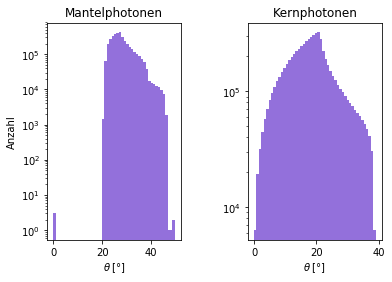

In [34]:
#------Theta berechnen und histogrammieren (für Mantel und Kern)----
data['theta']= np.arccos(data['px_start'])
data_clad['theta']= np.arccos(data_clad['px_start'])

plt.subplot(1,2,1)
array_m, bins_m, patches_m = plt.hist(data_clad['theta']*(360/2/np.pi), bins = 50, color ='mediumpurple')
plt.title(r'Mantelphotonen')
plt.xlabel(r'$\theta\;$[°]')
plt.ylabel(r'Anzahl')
plt.yscale('log')

plt.subplot(1,2,2)
array_c, bins_c, patches_c = plt.hist(data['theta']*(360/2/np.pi), bins = 50, color = 'mediumpurple')
plt.title(r'Kernphotonen')
plt.xlabel(r'$\theta\;$[°]')
plt.yscale('log')

plt.subplots_adjust(wspace = 0.5)
plt.savefig('../plots/Simulation/theta_sim.pdf')

#Winkel_Mantel = array_m[np.argmax(bins_m)]
#print(Winkel_Mantel)
Haeuf_Winkel_m = bins_m[np.argmax(array_m)]
Haeuf_Winkel_k = bins_c[np.argmax(array_c)]
print('häufigster Winkel Mantel:', Haeuf_Winkel_m)
print('häufigster Winkel Kern:', Haeuf_Winkel_k)


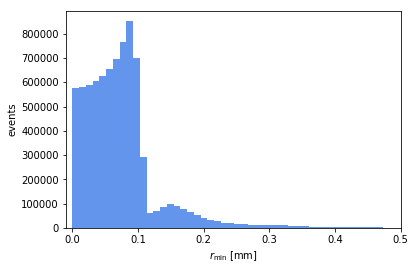

In [5]:
#----R_min berechnen und histogrammieren------
data['r_min'] = (np.abs(data['pz_start']*data['y_start']-data['py_start']*data['z_start']))/np.sqrt(data['pz_start']**2 + data['py_start']**2)
plt.hist(data['r_min'], color='cornflowerblue', bins=100)
plt.xlabel(r'$r_\mathrm{min}\;$[mm]')
plt.ylabel(r'events')
plt.xlim(-0.01, 0.5)
plt.savefig('../plots/Simulation/rmin_sim.pdf')

In [6]:
#Zuschnitt auf r_min innerhalb des Kernes?
data = data.loc[data['r_min']<0.11]

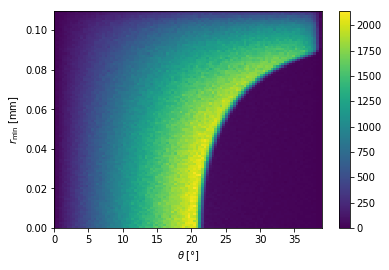

In [7]:
#---- Histogramm r_min, theta zur Mittelwertberechnung ---------
matrix_r, theta_r, r_min_r, image = plt.hist2d(data['theta']*(360/2/np.pi), data['r_min'], cmap='viridis', bins=100)
plt.ylabel(r'$r_\mathrm{min}\;$[mm]')
plt.xlabel(r'$\theta\;$[°]')
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()
plt.savefig('../plots/Simulation/hist_rmin_sim.pdf')

In [8]:
#-----------Mittelwertberechnung von r_min pro Winkel--------
mean_r_min = []
for i in range(0,len(theta_r)-1):
    sum = 0.0
    ctr = 0.0
    for j in range(0,len(r_min_r)-1):
        sum += matrix_r[i,j]*r_min_r[j]
        ctr += matrix_r[i,j]
    mean_r_min.append(sum/ctr)
#mean_r_min

a 0.06505938600303532 0.00021798195048428968
b -6.5418509041505075 0.19409826429410604
c 0.3585247579777788 0.009246123502762445


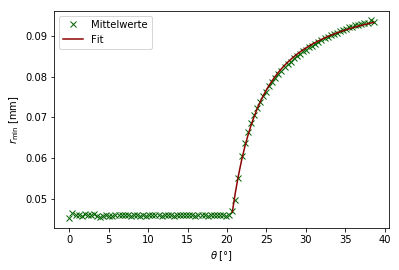

In [9]:
#---------Mittelwerte plotten-------
plt.plot(theta_r[:len(theta_r)-1], mean_r_min, color = 'darkgreen', linestyle='', marker ='x', label = r'Mittelwerte')
plt.ylabel(r'$r_\mathrm{min}\;$[mm]')
plt.xlabel(r'$\theta\;$[°]')

#--------Mittelwerte fitten----------
def fit(t, a, b, c):
    return a*np.arctan(b+c*t)

params, cov = curve_fit(fit, theta_r[53:len(theta_r)-1],  mean_r_min[53:],)
error = np.sqrt(np.diag(cov))

plt.plot(theta_r[53:len(theta_r)-1], fit(theta_r[53:len(theta_r)-1], *params), color = 'darkred', label =r'Fit')
plt.legend()
plt.savefig('../plots/Simulation/rmin_mean_sim.pdf')
print('a', params[0], error[0])
print('b', params[1], error[1])
print('c', params[2], error[2])
#print('d', params[3], error[3])

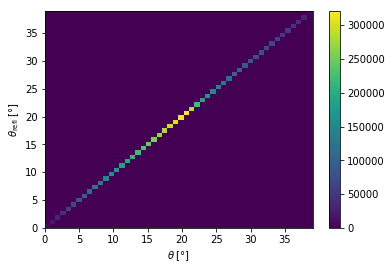

In [10]:
#---------Berechnung theta_refl----------
r_Kern = 110 #Mikrometer
data['theta_refl'] = np.arcsin(np.sqrt(1-((data['r_min']**2)/(r_Kern**2)))*np.sin(data['theta']))

#--------Histogramm zur Mittelwertberechnung von theta_refl pro Winkel-------------
matrix, theta, theta_refl, image = plt.hist2d(data['theta']*(360/2/np.pi), data['theta_refl']*(360/2/np.pi),cmap='viridis', bins=50)
plt.ylabel(r'$\theta_\mathrm{refl}\;$[°]')
plt.xlabel(r'$\theta\;$[°]')
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()
plt.savefig('../plots/Simulation/Theta_refl_sim.pdf')

In [11]:
#-------Mittelwertberechnung von theta_refl pro Winkel--------
mean_theta_refl = []
for i in range(0,len(theta)-1):
    sum = 0.0
    ctr = 0.0
    for j in range(0,len(theta_refl)-1):
        sum += matrix[i,j]*theta_refl[j]
        ctr += matrix[i,j]
    mean_theta_refl.append(sum/ctr)


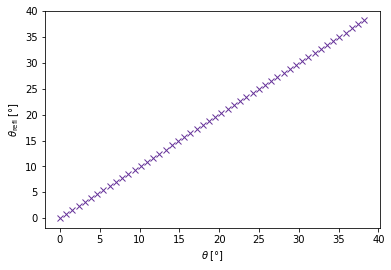

In [12]:
#-------Mittelwerte plotten----------
plt.plot(theta[:len(theta)-1], mean_theta_refl, color = 'rebeccapurple', linestyle='', marker ='x')
plt.ylabel(r'$\theta_\mathrm{refl}\;$[°]')
plt.xlabel(r'$\theta\;$[°]')
plt.savefig('../plots/Simulation/Theta_refl_mean_sim.pdf')

In [13]:
#-----Verhältniss Mantelphotonen zu Kernphotonen pro Winkel----
ratio = [] 
for i in range(0, len(bins_c)-1):
    ratio.append(array_m[i]/array_c[i])



In [14]:
#----------------Größte Winkel mit nur Kernphotonen------------
#Nur Kernphotonen -> # Mantelphotonen = 0 -> Ratio = 0
theta_just_core = []
y = [] #Zum plotten
for i in range(0, len(ratio)-1):
    if ratio[i] == 0:
        theta_just_core.append(bins_c[i])
        y.append(0)
        
theta_just_core_max = np.max(theta_just_core)
print(theta_just_core_max)


14.828276747436885


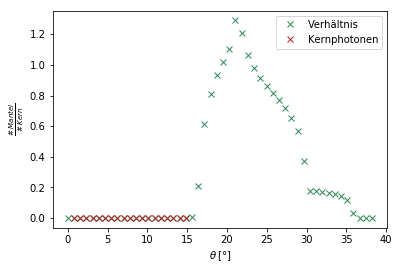

In [15]:
#---Verhältnis und Kernphotonen plotten-------
plt.plot(bins_c[:len(bins_c)-1], ratio, marker = 'x', linestyle = '', color = 'seagreen', label = r'Verhältnis')
plt.plot(theta_just_core, y, marker = 'x', linestyle = '', color = 'firebrick', label = r'Kernphotonen')
plt.xlabel(r'$\theta\;$[°]')
plt.ylabel(r'$\frac{\# \; Mantel}{\# \; Kern}$')
plt.legend()
plt.savefig('../plots/Simulation/ratio_sim.pdf')

In [16]:
#------Größter Winkel unter dem noch Photonen auftreten in Abhängigkeit von r_min-----
#Nutze Histogramm zur Mittelwertbestimmung von r_min
r_min_max = []
theta_max = []
for i in range(0, len(r_min_r)-1):
    for j in range(0, len(theta_r)-1):
        if matrix_r[i,j] <130:
            theta_max.append(theta_r[j-1])
            r_min_max.append(r_min_r[i])
            break

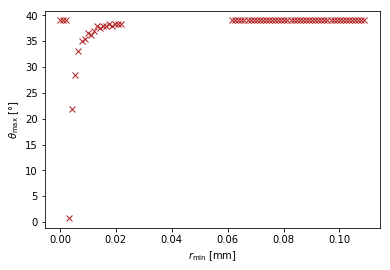

In [18]:
#------ Plot der maximalen Winkel in Abhängigkeit von r_min----------
plt.plot(r_min_max, theta_max, color = 'firebrick', marker = 'x', linestyle = '')
plt.xlabel(r'$r_\mathrm{min}\;$[mm]')
plt.ylabel(r'$\theta_\mathrm{max}\;$[°]')
plt.savefig('../plots/Simulation/theta_max_sim.pdf')

In [20]:
matrix_r

array([[ 25.,  27.,  18., ...,   4.,   3.,   3.],
       [ 59.,  72.,  67., ...,  15.,  12.,   7.],
       [103.,  96., 131., ...,  24.,  28.,  14.],
       ...,
       [ 12.,  12.,  11., ..., 367., 290., 162.],
       [  1.,   6.,   5., ..., 185., 153.,  88.],
       [  1.,   0.,   2., ...,   8.,  14.,  12.]])

Austrittswinkel alpha

In [ ]:
daten['Austrittswinkel'] = np.arcsin(np.sin(180-90-daten['theta']*(360/2/np.pi))*(1.6/3.882))
